<h1><center>Big Data Algorithms Techniques & Platforms</center></h1>
<h2>
<hr style=" border:none; height:3px;">
<center>Spark and DataFrames</center>
<hr style=" border:none; height:3px;">
</h2>

#A. Analysis of the ``Great Expectations`` - Charles Dickens

Suppose you have a file containing the text of the ``Great Expectation``, a novel written in English by Charles Dickens. You can see an excerpt below :

"I pointed to where our village lay, on the flat in-shore among the
alder-trees and pollards, a mile or more from the church.

The man, after looking at me for a moment, turned me upside down, and
emptied my pockets. There was nothing in them but a piece of bread.
When the church came to itself,—for he was so sudden and strong that he
made it go head over heels before me, and I saw the steeple under my
feet,—when the church came to itself, I say, I was seated on a high
tombstone, trembling while he ate the bread ravenously."



## <strong>Exercise 0.</strong> Support functions

In [29]:
### Write here all the import function and the support function you need for processing the text

!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar zxvf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local")
sc = SparkContext(conf = conf)
print("initialization successful!")

import numpy as np
import random as rn

seed_value=0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,461 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,274 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 2,965 kB in 2s (1,718 kB/s)
Reading package lists... Done
spark-3

ValueError: ignored

In [30]:
def load_text(filename):
  # 1. RDD creation
  lines = sc.textFile(filename)
  return lines

import re
def remove_patterns_ex1(line):
    # Remove [Illustration] and occurrences of Chapter XX
    cleaned_line = re.sub(r'chapter [xlivvixlc]+[.]', '', line)
    cleaned_line = cleaned_line.replace("[illustration]", "")
    cleaned_line = cleaned_line.replace("mr.", "mr").replace("mrs.", "mrs").replace("ms.", "ms").replace(",","")
    return cleaned_line

def remove_patterns_ex3(line):
# Remove [Illustration] and the first occurrence of Chapter XX
    cleaned_line = line.replace("[Illustration]", "")
    cleaned_line = cleaned_line.replace("Mr.", "Mr").replace("Mrs.", "Mrs").replace("Ms.", "Ms")
    return cleaned_line


def load_stopwords(stopwords_file):
    stopwords = []
    with open(stopwords_file) as file:
        for sw in file:
            stopwords.append(sw.strip())
    return stopwords

stopwords = load_stopwords("stopwords.txt")

def remove_stopwords(text, stopwords):

    # 1. Removing stopwords from each line and converting to lowercase
    cleaned_lines = text.map(lambda line: ' '.join([word for word in line.split() if word.lower() not in stopwords]))

    return cleaned_lines


In [31]:
great_expectations = load_text('great_expectations.txt')
print("Successfully loaded the file in a RDD")

Successfully loaded the file in a RDD


## <strong>Exercise 1</strong> Word number in sentences

The length of a sentence is the number of words that compose the sentence.

Write and comment on the set of Spark operations that return how many sentences we have for each available length in the text. You must also show the five most common lengths.

Notice that in the available text, a sentence is a set of lines that ends with a strong punctuation mark (i.e., ".", "!", "?", etc.).

Notice that:

* The novel starts after the <code> *** START OF THE PROJECT GUTENBERG EBOOK GREAT EXPECTATIONS ***</code>

* <code> [Illustration] </code> is not a sentence

* <code>Chapter VIII.</code> is not a sentence

You can introduce your constraints for the parsing. Multiple solutions and points of view are correct. You must comment on your point of view (i.e., the definition of ``sentence'' in your analysis).

You can choose if you are considering the stop-words in the count: add your point of view in the comment.

In [32]:
############## WRITE YOUR CODE HERE ##############

# For this exercise I am going to consider all the sentences in the book great expectations
# To do this I realised that I only need the text starting from "My father’s family name being Pirrip, and my Christian name Philip, my"
# and ending at "*** END OF THE PROJECT GUTENBERG EBOOK GREAT EXPECTATIONS ***"
# I choose this start line as I did not want to include the title and other parts of the text like the title in the word counts like
# Great Expectations
# [1867 Edition]
# by Charles Dickens
#The method I used to


start_line = "My father’s family name being Pirrip, and my Christian name Philip, my"
end_line = "*** END OF THE PROJECT GUTENBERG EBOOK GREAT EXPECTATIONS ***"
start_index = great_expectations.zipWithIndex().filter(lambda x: x[0].strip() == start_line).map(lambda x: x[1]).first()
end_index = great_expectations.zipWithIndex().filter(lambda x: x[0].strip() == end_line).map(lambda x: x[1]).first()

# Filter the RDD to include lines starting from start_line and convert each line to lowercase
filtered_text = great_expectations.zipWithIndex().filter(lambda x: start_index <= x[1] < end_index).map(lambda x: x[0].lower())

# Remove patterns
cleaned_text = filtered_text.map(remove_patterns_ex1)

#Remove stopwords
great_expectations_preprocessed = remove_stopwords(cleaned_text, stopwords)

# Combine all lines in the text file into a single string, separating paragraphs with a newline character
full_text = great_expectations_preprocessed.reduce(lambda x, y: x + "\n" + y)

# Split the combined text into paragraphs
paragraphs = full_text.split("\n\n")  # Assuming there is a blank line between paragraphs

# Replace '\n' with a space in each paragraph
paragraphs_with_spaces = [paragraph.replace('\n', ' ') for paragraph in paragraphs]

# Split each paragraph into sentences and filter out empty sentences
sentences_per_paragraph = [filter(lambda sentence: len(sentence.strip()) > 0, re.split(r'\. |\? |." |!" |! ', paragraph)) for paragraph in paragraphs_with_spaces]

# Flatten the list of sentences per paragraph
sentences = [sentence for sentences_in_paragraph in sentences_per_paragraph for sentence in sentences_in_paragraph]

# Count the number of words in each sentence
word_count_per_sentence = sc.parallelize(sentences).map(lambda sentence: (sentence, len(sentence.split())))

# Aggregate the sentence word counts
total_word_counts = word_count_per_sentence.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y)

# Display the top 5 most common sentence word counts
top_word_counts = total_word_counts.takeOrdered(5, key=lambda x: -x[1])
print("Top 5 most common sentence word counts:")
for word_count, count in top_word_counts:
    print(f"Word Count: {word_count}, Count: {count}")

# Order the word counts by word count
ordered_word_counts = total_word_counts.sortByKey()

# Display all sentence word counts
all_word_counts = ordered_word_counts.collect()
print("\nAll sentence word counts:")
for word_count, count in all_word_counts:
    print(f"Word Count: {word_count}, Count: {count}")

Top 5 most common sentence word counts:
Word Count: 4, Count: 750
Word Count: 3, Count: 725
Word Count: 5, Count: 700
Word Count: 2, Count: 655
Word Count: 6, Count: 614

All sentence word counts:
Word Count: 1, Count: 342
Word Count: 2, Count: 655
Word Count: 3, Count: 725
Word Count: 4, Count: 750
Word Count: 5, Count: 700
Word Count: 6, Count: 614
Word Count: 7, Count: 562
Word Count: 8, Count: 575
Word Count: 9, Count: 547
Word Count: 10, Count: 481
Word Count: 11, Count: 417
Word Count: 12, Count: 377
Word Count: 13, Count: 358
Word Count: 14, Count: 288
Word Count: 15, Count: 225
Word Count: 16, Count: 189
Word Count: 17, Count: 206
Word Count: 18, Count: 163
Word Count: 19, Count: 135
Word Count: 20, Count: 122
Word Count: 21, Count: 104
Word Count: 22, Count: 75
Word Count: 23, Count: 64
Word Count: 24, Count: 55
Word Count: 25, Count: 37
Word Count: 26, Count: 43
Word Count: 27, Count: 43
Word Count: 28, Count: 23
Word Count: 29, Count: 29
Word Count: 30, Count: 18
Word Count:

## <strong>Exercise 2.</strong> The average length of sentences in the entire novel
Write and comment on the set of Spark operations that returns and shows the average length of the sentences in the novel.

In [33]:
############## WRITE YOUR CODE HERE ##############

# Calculate the average number of words in sentences
total_word_counts = word_count_per_sentence.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y)

# Calculate the total number of sentences and the total word count
total_sentences = total_word_counts.map(lambda x: x[1]).sum()
total_words = total_word_counts.map(lambda x: x[0] * x[1]).sum()

# Calculate the average number of words per sentence
average_words_per_sentence = total_words / total_sentences

print(f"Average number of words per sentence: {average_words_per_sentence}")



Average number of words per sentence: 9.465316009689495


## <strong>Exercise 3.</strong> Average length in chapters

Write and comment on the set of Spark operations that returns and shows the average length of sentences in each chapter.

In [34]:
############## WRITE YOUR CODE HERE ##############

# For this exercise I am going to consider all the sentences in the book great expectations and the chapter headings
# To do this I realised that I realised that the startline and end_line that I used in exercise 1 were not appropriate so I have
#Initialised a new start_line_3 and end_line_3. I have also initialised new variables to avoid any mistakes
# To split the chapters I used regex


start_line_3 = "Chapter LIX."
end_line_3 = "*** END OF THE PROJECT GUTENBERG EBOOK GREAT EXPECTATIONS ***"
start_index_3 = great_expectations.zipWithIndex().filter(lambda x: x[0].strip() == start_line_3).map(lambda x: x[1]).first()
end_index_3 = great_expectations.zipWithIndex().filter(lambda x: x[0].strip() == end_line_3).map(lambda x: x[1]).first()

# Filter the RDD to include lines starting from start_line and convert each line to lowercase
filtered_text_3 = great_expectations.zipWithIndex().filter(lambda x: start_index_3 < x[1] < end_index_3).map(lambda x: x[0])

# Remove patterns
cleaned_text_3 = filtered_text_3.map(remove_patterns_ex3)

#Remove stopwords
great_expectations_preprocessed_3 = remove_stopwords(cleaned_text_3, stopwords)

# Combine all lines in the text file into a single string, separating paragraphs with a newline character
full_text_3 = '\n'.join(great_expectations_preprocessed_3.glom().map(lambda x: ' '.join(x)).collect())

# Use regex to split the text into chapters
chapters = re.split(r'\bChapter\b [XLIVVIXLC]+\.', full_text_3)[1:]

# Function to calculate the average sentence length
def average_sentence_length(chapter):
    # Split the chapter into sentences and filter out empty sentences
    sentences = list(filter(lambda sentence: len(sentence.strip()) > 0, re.split(r'[.!?]\s', chapter)))

    # Calculate the average sentence length
    total_words = sum(len(sentence.split()) for sentence in sentences)
    total_sentences = len(sentences)

    return total_words / total_sentences if total_sentences > 0 else 0

# Calculate and print the average sentence length for each chapter
for i, chapter in enumerate(chapters, 1):
    avg_length = average_sentence_length(chapter)
    print(f"Chapter {i}: Average Sentence Length = {avg_length:.2f} words")

Chapter 1: Average Sentence Length = 12.67 words
Chapter 2: Average Sentence Length = 14.32 words
Chapter 3: Average Sentence Length = 11.25 words
Chapter 4: Average Sentence Length = 13.05 words
Chapter 5: Average Sentence Length = 11.03 words
Chapter 6: Average Sentence Length = 15.45 words
Chapter 7: Average Sentence Length = 14.82 words
Chapter 8: Average Sentence Length = 12.71 words
Chapter 9: Average Sentence Length = 11.52 words
Chapter 10: Average Sentence Length = 12.52 words
Chapter 11: Average Sentence Length = 12.51 words
Chapter 12: Average Sentence Length = 13.58 words
Chapter 13: Average Sentence Length = 14.61 words
Chapter 14: Average Sentence Length = 12.89 words
Chapter 15: Average Sentence Length = 11.63 words
Chapter 16: Average Sentence Length = 13.42 words
Chapter 17: Average Sentence Length = 13.94 words
Chapter 18: Average Sentence Length = 10.83 words
Chapter 19: Average Sentence Length = 13.17 words
Chapter 20: Average Sentence Length = 13.98 words
Chapter 2

## <strong>Exercise 4.</strong> The most repeated words in the sentences

Write and comment on the set of Spark operations that returns the ten most repeated words in a sentence and their repetition rate.

For example, the most repeated word in this set of sentences is <code> cat </code>, with an average repetition rate of 2. The word <code> table </code> is not considered as repeated.

* The cat is on the cat table.
* The table is red.
* The wooden table is broken.



In [36]:
#For this exercise, I did the following steps.
# 1) I created a dictionary called repeated_words. This dictionary has a key and a value that is an array with 3 elements
# 2) Now I for each sentence in sentences_rdd I tokenized the sentence into words and checked for duplicates
# 3) If the sentence had repeating words I checked if those words existed in the dictionary repeated words
# 4) If they existed in the dictionary I appended the value with the number of times they occured and added 1 to the sentence count
#    If they didn't exist I added them to the dictionary
# 5) After this loop completed, I created a for loop through the dictionary repeated_words that calculated the repetition rate
# and added it to the values array for each word in the dictionary
# 6) Finally I printed the top 10 words with the highest repetition rate

repeated_words = {}


# Create an RDD from the list of sentences
sentences_rdd = sc.parallelize(sentences)

# sentences_rdd is the RDD containing the list of sentences
for sentence_no, sentence in enumerate(sentences_rdd.collect(), 1):
    # Tokenize the sentence into words
    words = sentence.split()

    # Count occurrences of each word in the sentence
    word_count = {}
    for word in words:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    # Check for repeating words in the sentence
    for word, count in word_count.items():
        if count > 1:
            # Check if the word is already in the repeated_words dictionary
            if word in repeated_words:
                # If yes, update the count and sentence_no
                repeated_words[word][0] += count
                repeated_words[word][1] += 1
            else:
                # If no, add the word to the dictionary with initial values
                repeated_words[word] = [count, 1]

# Calculate the repetition rate after the for loop
for word, values in repeated_words.items():
    values.append(values[0] / values[1] if values[1] > 0 else 0)

# Print only the top 10 words with highest repetition rates
print("Top 10 words with the highest repetition rates:")
for word, values in sorted(repeated_words.items(), key=lambda x: x[1][2], reverse=True)[:10]:
    print(f"Word: {word}, Repetition Rate: {values[2]}")

Top 10 words with the highest repetition rates:
Word: jail, Repetition Rate: 6.0
Word: hears, Repetition Rate: 4.0
Word: she’d, Repetition Rate: 4.0
Word: believed, Repetition Rate: 4.0
Word: rul, Repetition Rate: 4.0
Word: dismal, Repetition Rate: 4.0
Word: bit, Repetition Rate: 4.0
Word: mud, Repetition Rate: 4.0
Word: molly, Repetition Rate: 4.0
Word: vanity, Repetition Rate: 4.0


# B. Coffee Dataset

<p align="justify">
<font size="3">
For running this series of exercises, we are going to use a dataset coming from <a href="https://www.kaggle.com/datasets/schmoyote/coffee-reviews-dataset">Kaggle</a>.

As stated in the description of the dataset:
"Dataset contains information about coffee production and consumption.

All data are available from the official ICO website:
https://www.ico.org/new_historical.asp".
</font>
</p>


### The dataset

<p align="justify">
<font size="3">
The dataset is in a .csv file, and among the columns, you can find:

<ul>
<li> <code>name</code> The name of the blend </li>
<li><code>roaster</code> The name of the roaster</li>
<li><code>roast</code> The type of roast</li>
<li><code>loc_country</code> The country of the roaster</li>
<li><code>...</code> ...</li>
</ul>
</p>
</font>



In [37]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [38]:
! kaggle datasets download schmoyote/coffee-reviews-dataset

coffee-reviews-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [39]:
!unzip coffee-reviews-dataset.zip

Archive:  coffee-reviews-dataset.zip
replace coffee_analysis.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace simplified_coffee.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [40]:
# Add your imports
from pyspark.sql import SparkSession
import pandas as pa
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("CSVImport").getOrCreate()

# Specify the path to your CSV file
csv_path = "simplified_coffee.csv"

## <strong> Spark and Pandas.</strong>

For this set of exercises, you must import data in Spark. After this first import, you can pass any dataset to Pandas for data analysis. At the end of each exercise (when the question is pertinent), you must return (reconvert) the dataframe in Spark.

Each time you do this conversion you must comment about this. Example:

<code> # creating a Spark dataframe </code>

<code> df = ... </code>

<code> # using Pandas and creating a Pandas dataframe </code>

<code> dfp = df. ... </code>

<code> # back to Spark </code>

<code> dfs = ... </code>

## <strong> Exercise 5.</strong> First import and data type
Import the .csv file in Spark DataFrame and show the structure of the dataframe.

Check and comment about the data type of each column. As you know, a good data analysis always starts from understanding your dataset.

In [41]:
# Write the command that creates (reads) a Spark DataFrame and stores the reference in the dfs variable

#'''############## WRITE HERE YOUR CODE ##############'''
dfs = spark.read.csv(csv_path, header=True, inferSchema=True)

# show the DataFrame schema
dfs.printSchema()

###### Write here your comment ##############
# from the print schema we can see that these are the data types for each column
# |-- name: string (nullable = true) - I believe this sould be a Primary key or part of a primary key with roaster as this dataset does not have a column that is unique
# |-- roaster: string (nullable = true) -  I think this column too should be part of a primary key
# |-- roast: string (nullable = true) - This could be a categoriacal data type
# |-- loc_country: string (nullable = true) - This could also be aa categorical data type
# |-- origin: string (nullable = true) - This could also be aa categorical data type
# |-- 100g_USD: double (nullable = true) - This column is the price of 100 gms of coffee and is correctly written as a double
# |-- rating: integer (nullable = true) - This column is stores the ratings of each coffee as an integer
# |-- review_date: string (nullable = true) - This column stores the date of review as a string. Ideally it should be a DateTime value
# |-- review: string (nullable = true) - THis column stores the review as a string



root
 |-- name: string (nullable = true)
 |-- roaster: string (nullable = true)
 |-- roast: string (nullable = true)
 |-- loc_country: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- 100g_USD: double (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review: string (nullable = true)



## <strong> Exercise 6.</strong> Data modeling choices
    
<p align="justify">
<font size="3">
Comment on the data-modeling choices and if you consider them correct from a general data-modeling point of view.
</font>
</p>


In [42]:
###### Write here your comment

# Overall the data modelling choices in this file are correct there are a few modifications I would propose to improve the current structure
# 1) Changing the data type of review_date to a Date Time type
# 2) String is an appropriate data type for fields like name roaster but we can consider using categorical data types for Origin, loc_country, roast
# Categorical data types save memory and improve performance. It also improves data quality as there is less
# chance of a typo or error in spelling for field with a a categorical data type


## <strong> Exercise 7.</strong>  Best rated coffees
    
<p align="justify">
<font size="3">
We want to find the 5 best rated coffees.
</font>
</p>

In [43]:
#Converting to a pandas dataframe
dfp = dfs.toPandas()
top_5_coffees = dfp.sort_values(by='rating', ascending=False).head(5)

#Reconverting to a spark dataframe
spark_df = spark.createDataFrame(top_5_coffees)

# Show the result
spark_df.show()


+--------------------+--------------------+------------+-------------+--------+--------+------+-------------+--------------------+
|                name|             roaster|       roast|  loc_country|  origin|100g_USD|rating|  review_date|              review|
+--------------------+--------------------+------------+-------------+--------+--------+------+-------------+--------------------+
|Panama Ninety Plu...|Bird Rock Coffee ...|Medium-Light|United States|  Panama|   26.46|    97| January 2019|Wild, unruly, utt...|
|        Rukera Kenya| JBC Coffee Roasters|Medium-Light|United States|   Kenya|    6.23|    97|    July 2019|Lavish, captivati...|
|Colombia Finca El...|   Paradise Roasters|       Light|United States|Colombia|   35.27|    97|February 2022|Ultra-high-toned,...|
|Ethiopia Natural ...|       Kakalove Cafe|Medium-Light|       Taiwan|Ethiopia|    5.66|    97| October 2020|Luminous, clear, ...|
|     100% Kona SL-28|Hula Daddy Kona C...|Medium-Light|      Hawai'i| Hawai'I|   3

## <strong> Exercise 8.</strong> The best 10 roasters
<p align="justify">
<font size="3">
We want to find the ten best roasters. It is up to you to define and refine the ``best'' metric (best in the platform from the beginning of data collection, best in the last three years, best and with a minimum number of ratings, etc.).

Add the definition of your best metric in the comments.
</font>
</p>

In [44]:
# To find the 10 best roasters. I defined the main metric as the roasters with more than one review
# Since we are looking at best roasters and not best speciality roasters more reviws are liketly to
# imply that the roaster has more than one variety. Also more ratings for a sincle roaster provide a
# balanced view of the roaster quality.
# I choose this approach because if I sorted by rating, there are a high number of roasters with a
# rating of 97. But single reviews can be biased. It depends on the reviewrs taste and palatte.
# For example Hula Daddy Kona Coffee has 24 ratings that vary from 97 to 93. Therefore their avrage rating
# is a true indicator of their quality.

# To find the top 10 roasters usig this method I calculated it as follows
# 1. It looks for duplicate instaces of the roaster.
# 2. It then groups the rating and roaster.
# 3. it calculates the average rating per roaster and the number of ratings per roaster
# 4. It finally sorts the top ten roasters by average ratings that have more than 10 reviews.
# 5. Lastly I convert the panda dataframe back to spark


duplicates = dfp[dfp.duplicated(subset='roaster', keep=False)]

# Assuming 'duplicates' is your Pandas DataFrame with duplicate values
grouped_data = duplicates.groupby('roaster')['rating']

# Calculate average ratings and counts
average_ratings = grouped_data.agg(['mean', 'count']).reset_index()

# Rename columns for clarity
average_ratings.columns = ['roaster', 'average_rating', 'rating_count']

# Filter rows where rating count is greater than 10
filtered_ratings = average_ratings[average_ratings['rating_count'] > 10]

# Sort the DataFrame by average ratings in descending order
filtered_ratings = filtered_ratings.sort_values(by='average_rating', ascending=False)

# Display the top 10 rows in a spark dataframe
roasters_df = spark.createDataFrame(filtered_ratings).limit(10)

# Show the resulting Spark DataFrame
roasters_df.show()



+--------------------+-----------------+------------+
|             roaster|   average_rating|rating_count|
+--------------------+-----------------+------------+
|Hula Daddy Kona C...|           95.125|          24|
|Dragonfly Coffee ...|94.33333333333333|          30|
|Red Rooster Coffe...|94.33333333333333|          18|
|       Kakalove Cafe|94.26373626373626|          91|
|Bird Rock Coffee ...|94.24137931034483|          29|
|           GK Coffee|            94.04|          25|
|       Coffee Please|93.92307692307692|          13|
|   Paradise Roasters|  93.855421686747|          83|
| JBC Coffee Roasters|93.67032967032966|          91|
|       modcup coffee|93.66666666666667|          12|
+--------------------+-----------------+------------+



## <strong> Exercise 9.</strong> Best country
<p align="justify">
<font size="3">
If you were a roaster, in which three countries would you try to set your business?

Show them and refine your metric definition if necessary.
</font>
</p>


In [45]:
# As a roaster to know the best country to set up my business I need to evaluate a few things.
# 1. The average cost of coffee in different countries
# 2. The number of unique roasters in each counrty
# (Extra) 3. Content of the reviews from each country I used additional libraries to do this analysis
# 4. Final comments (at the end of this cell)

# This will give me an idea of the type of coffee already available, the amount of competition
# in these countries and the average cost tells me how much the customers are willing to pay for
#coffee


# 1. The average cost of coffee in different countries
average_cost_per_country = dfp.groupby('loc_country')['100g_USD'].mean()

# 2. The number of unique roasters in each country
unique_roasters_per_country = dfp.groupby('loc_country')['roaster'].nunique()

# 1. The average cost of coffee in different countries
average_ratings_per_country = dfp.groupby('loc_country')['rating'].mean()

# Combine the results into a single DataFrame
result_df = pa.DataFrame({
    'Country': unique_roasters_per_country.index,
    'Average Cost': average_cost_per_country.values,
    'Unique Roasters': unique_roasters_per_country.values,
    'Average Rating': average_ratings_per_country
})

# Sort the DataFrame by 'Unique Roasters' in descending order
result_df = result_df.sort_values(by='Unique Roasters', ascending=False)

# Truncate 'Average Cost' and 'Average Rating' to two decimal points
result_df['Average Cost'] = result_df['Average Cost'].round(2)
result_df['Average Rating'] = result_df['Average Rating'].round(2)

# Convert the Pandas DataFrame to a Spark DataFrame
roastersCountry_df = spark.createDataFrame(result_df)

# Show the resulting Spark DataFrame
roastersCountry_df.show()

#Final comments
# Reviews in the top 3 countries indicate customer preferences for Sweet and cocao/ choclat flavours
# If I was a roaster with a good quality roast I would choose to set up in Taiwan or Hawai'i due to the
# better average cost and lesser competition. However I would also do further analysis on the
# different roasts in the different countries and decide based on that.

+-------------+------------+---------------+--------------+
|      Country|Average Cost|Unique Roasters|Average Rating|
+-------------+------------+---------------+--------------+
|United States|        9.26|            172|         93.25|
|       Taiwan|       10.08|             92|         93.64|
|      Hawai'i|       18.15|             17|         93.42|
|       Canada|        4.99|              5|          93.6|
|    Hong Kong|       15.62|              3|         92.67|
|        Japan|       10.75|              3|         92.38|
|      England|       92.18|              2|         94.14|
|    Guatemala|        3.55|              2|          90.5|
|    Australia|        69.0|              1|          96.0|
|        China|       22.53|              1|          90.0|
|        Kenya|        6.91|              1|          94.0|
|   New Taiwan|        9.46|              1|          93.0|
+-------------+------------+---------------+--------------+



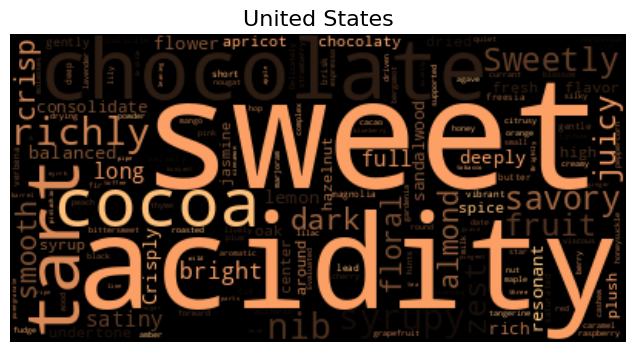

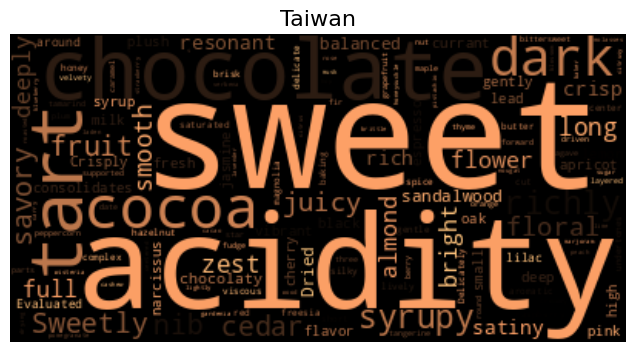

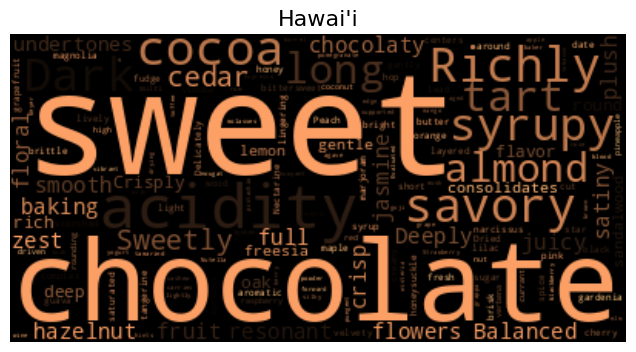

In [46]:
# (Extra) Content of the reviews from each of the Top 3 countries. (I used additional
# python libraries to do this analysis)

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
def make_cloud_word(value):
    text = " ".join(review for review in dfp.loc[dfp["loc_country"] == value, "review"])
    stopwords_coffee = set(STOPWORDS)
    stopwords_coffee.update(["drink", "now", "cup", "toned", "note", "finish", "aroma", "notes", "hint", "mouthfeel", "structure"])
    wordcloud = WordCloud(stopwords=stopwords_coffee,collocations=False, colormap="copper", random_state=11).generate(text)
    plt.figure(figsize=(8,4))
    plt.title(value, size=16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show();

make_cloud_word("United States")
make_cloud_word("Taiwan")
make_cloud_word("Hawai'i")

## <strong> Exercise 10.</strong> Less common origin
<p align="justify">
<font size="3">
Show the ten less common origins of the coffees.

</font>
</p>

In [47]:
############## WRITE YOUR CODE HERE AND THE DESCRIPTION OF YOUR "SOMEHOW" ##############
# Display the values in the 'origin' column and their count
origin_count = dfs.groupBy("origin").count().orderBy("count").limit(10)

# Show the result
origin_count.show()


+------------------+-----+
|            origin|count|
+------------------+-----+
|          Thailand|    2|
|          Tanzania|    2|
|           Bolivia|    2|
|Dominican Republic|    2|
|            Uganda|    2|
|       Philippines|    2|
|             Nepal|    2|
|          Honduras|    6|
|           Ecuador|    8|
|            Taiwan|    9|
+------------------+-----+



## <strong> Exercise 11.</strong>  Propose your own analysis



    
<p align="justify">
<font size="3">
Propose here an analysis on the dataframe.
</font>
</p>

In [48]:
# To understand in depth, where I should set up a coffee business or where a roaster must sell, I propose a deeper analysis
# in to the number of roasters in per roast types grouped by country
# This helps us see that the roasst produced my the most numbe of roasters is Medium light in USA, Hawai'i and Taiwan.
#

# Group by 'loc_country' and 'roast', then count the number of roasters
roasters_count_per_roast = dfp.groupby(['loc_country', 'roast'])['roaster'].count().reset_index()

# Rename the count column for clarity
roasters_count_per_roast = roasters_count_per_roast.rename(columns={'roaster': 'Roaster Count'})

# Convert the Pandas DataFrame to a Spark DataFrame
analysis_df = spark.createDataFrame(roasters_count_per_roast)

# Show the resulting Spark DataFrame
analysis_df.show(40)

+-------------+------------+-------------+
|  loc_country|       roast|Roaster Count|
+-------------+------------+-------------+
|    Australia|Medium-Light|            1|
|       Canada|      Medium|            1|
|       Canada|Medium-Light|            4|
|        China|       Light|            1|
|      England|Medium-Light|            2|
|    Guatemala|       Light|            4|
|    Guatemala|      Medium|            5|
|    Guatemala| Medium-Dark|            1|
|    Guatemala|Medium-Light|           14|
|      Hawai'i|       Light|            2|
|      Hawai'i|      Medium|           15|
|      Hawai'i| Medium-Dark|            1|
|      Hawai'i|Medium-Light|           59|
|    Hong Kong|       Light|            1|
|    Hong Kong|      Medium|            1|
|    Hong Kong|Medium-Light|            7|
|        Japan|       Light|            7|
|        Japan|Medium-Light|            1|
|        Kenya|Medium-Light|            1|
|   New Taiwan|       Light|            1|
|       Tai